# Compare versions of AusEFlux NEE

**Version 2.1** of AusEFlux was created to operationalise the research datasets published in the [EGU Biogeosciences publication](https://doi.org/10.5194/bg-20-4109-2023). In order to operationalise these datasets, changes to the input datasets were required to align the data sources with datasets that are regularly and reliably updated, along with general improvements. This notebook creates a series of plots demonstrating the differences between the research datasets (version 1.1) and the operational datasets (version 2.1). 

This noteboook looks at the variable **<ins>Net Ecosystem Exchange<ins>**, and the notebook will show the differences between versions by examining:
* Aggregated time series across the Australian continent
* Per pixel correlation and deviation
* Seasonal cycles, including disaggregation by bioclimatic zone
* Linear trends
  
***
Some key differences on the input datasets between versions are listed below, along with the differences in specifications.

**Spatial resolution**:
* Version 1.1 = 0.01&deg; (~1 km)
* Version 2.1 = 0.005&deg; (~500 m)

**Temporal resolution and range**:
* Version 1.1 = Monthly, January 2003 - July 2022
* Version 2.1 = Monthly, January 2003  -  December 2024 (updated annually)

**Input data sources**

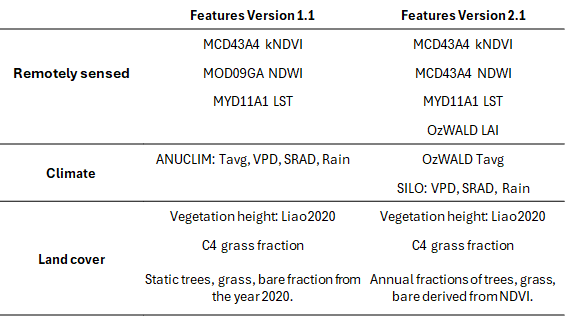


## Import libraries

In [ ]:
import os
import pickle
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import xskillscore as xs
import contextily as ctx
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/xc0/project/AusEFlux/src/')
from _utils import round_coords

## Start dask client

In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

## Analysis Parameters

In [3]:
var = 'NEE'

## Open version 1 & 2

In [4]:
base = f'/g/data/ub8/au/AusEFlux/'

folder = f'{base}v1/monthly/{var}'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
ds_v1 = xr.open_mfdataset(files).sel(time=slice('2003','2021'))
ds_v1 = assign_crs(ds_v1, crs='EPSG:4326')
ds_v1.attrs['nodata'] = np.nan

base = f'/g/data/xc0/project/AusEFlux/results/AusEFlux/'
# folder = f'{base}v2/monthly/{var}'
folder = f'{base}v2.1/{var}'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
ds_v2 = xr.open_mfdataset(files).sel(time=slice('2003','2021'))
ds_v2 = assign_crs(ds_v2, crs='EPSG:4326')
ds_v2.attrs['nodata'] = np.nan

## Reproject to common grid

We'll use 5km to speed things up

In [5]:
# Grab a common grid to reproject too
gbox_path = f'/g/data/xc0/project/AusEFlux/data/grid_5km'
with open(gbox_path, 'rb') as f:
    gbox = pickle.load(f)

ds_v1 = ds_v1.odc.reproject(how=gbox, resampling='bilinear').compute()
ds_v2 = ds_v2.odc.reproject(how=gbox, resampling='bilinear').compute()

ds_v1 = round_coords(ds_v1)
ds_v2 = round_coords(ds_v2)

/g/data/xc0/project/AusEFlux/env/py310/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


## Australia-wide time-series

In [6]:
# Long term means
mean_v1= ds_v1.mean('time')
mean_v2 = ds_v2.mean('time')

#nan mask
mask = ~np.isnan(mean_v2[f'{var}_median'])

# Annual mean timeseries
annual_mean_v1 = ds_v1.resample(time='YE').sum().where(mask)
annual_mean_v2 = ds_v2.resample(time='YE').sum().where(mask)

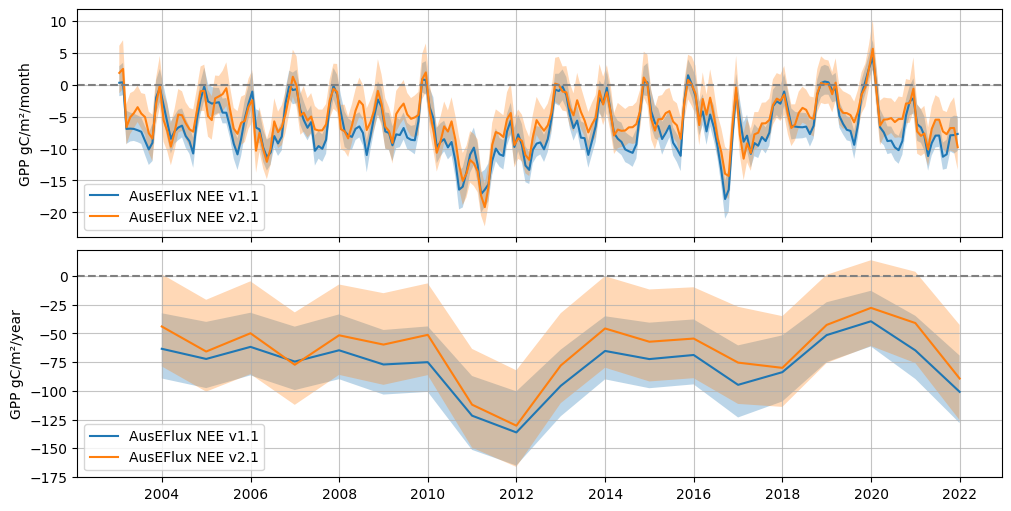

In [7]:
fig,ax=plt.subplots(2,1, figsize=(10,5), layout='constrained', sharex=True)

ds_v1[f'{var}_median'].mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'AusEFlux {var} v1.1')
upper_v1 = ds_v1[f'{var}_25th_percentile'].mean(['latitude', 'longitude'])
lower_v1 = ds_v1[f'{var}_75th_percentile'].mean(['latitude', 'longitude'])
ax[0].fill_between(ds_v1.time, lower_v1, upper_v1, alpha=0.3)

ds_v2[f'{var}_median'].mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'AusEFlux {var} v2.1')
upper_v2 = ds_v2[f'{var}_25th_percentile'].mean(['latitude', 'longitude'])
lower_v2 = ds_v2[f'{var}_75th_percentile'].mean(['latitude', 'longitude'])
ax[0].fill_between(ds_v2.time, lower_v2, upper_v2, alpha=0.3)

annual_mean_v1[f'{var}_median'].mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'AusEFlux {var} v1.1')
upper_v1 = annual_mean_v1[f'{var}_25th_percentile'].mean(['latitude', 'longitude'])
lower_v1 = annual_mean_v1[f'{var}_75th_percentile'].mean(['latitude', 'longitude'])
ax[1].fill_between(annual_mean_v1.time, lower_v1, upper_v1, alpha=0.3)

annual_mean_v2[f'{var}_median'].mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'AusEFlux {var} v2.1')
upper_v2 = annual_mean_v2[f'{var}_25th_percentile'].mean(['latitude', 'longitude'])
lower_v2 = annual_mean_v2[f'{var}_75th_percentile'].mean(['latitude', 'longitude'])
ax[1].fill_between(annual_mean_v2.time, lower_v2, upper_v2, alpha=0.3)

ax[0].axhline(0, c='grey', linestyle='--')
ax[1].axhline(0, c='grey', linestyle='--')
ax[0].grid(alpha=0.75)
ax[1].grid(alpha=0.75)
ax[0].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/month')
ax[1].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/year')
ax[0].set_xlabel(None)
ax[0].set_title(None)
ax[1].set_title(None)
ax[1].set_xlabel(None)
ax[0].legend()
ax[1].legend();

## Per pixel comparison

In [8]:
corr = xr.corr(ds_v2[f'{var}_median'], ds_v1[f'{var}_median'], dim='time').rename('Pearson Correlation')

cv = xs.rmse(ds_v2[f'{var}_median'], ds_v1[f'{var}_median'], dim='time', skipna=True).rename('CV')
# cv = cv/annual_mean_v2[f'{var}_median'].mean('time')

corr_data = [annual_mean_v1[f'{var}_median'].mean('time'),
             annual_mean_v2[f'{var}_median'].mean('time'),
             cv,
             corr]

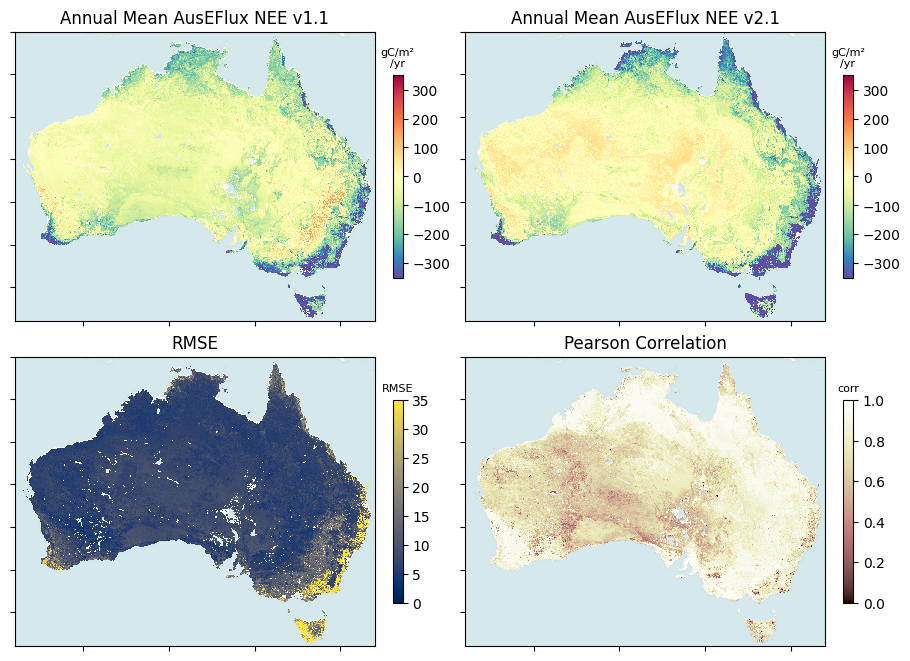

In [9]:
products=[f'Annual Mean AusEFlux {var} v1.1', f'Annual Mean AusEFlux {var} v2.1', 
          'RMSE', 'Pearson Correlation']
cmaps = ['Spectral_r', 'Spectral_r', 'cividis', 'pink']

fig,axes = plt.subplots(2,2, figsize=(9,6.5), sharey=True, sharex=True, layout='constrained')

for ax, ds, n, cmap in zip(axes.ravel(), corr_data, products, cmaps):
    if cmap=='pink':
        vmin=0
        vmax=1.0
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='corr'

    if cmap=='cividis':
        vmin = 0
        vmax = 35
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='RMSE'

    if cmap=='Spectral_r':
        vmin=-350
        vmax=350
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='gC/m\N{SUPERSCRIPT TWO}\n/yr'

    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.ax.set_title(title, fontsize=8)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])


## Seasonal cycles

In [10]:
#calculate climatology
clim_v1 = ds_v1.groupby('time.month').mean()
clim_v2 = ds_v2.groupby('time.month').mean()

### Aus-wide seasonal cycle

We will also open and plot bioclimatic regions alongside so the regions are obvious for the subsequent plots

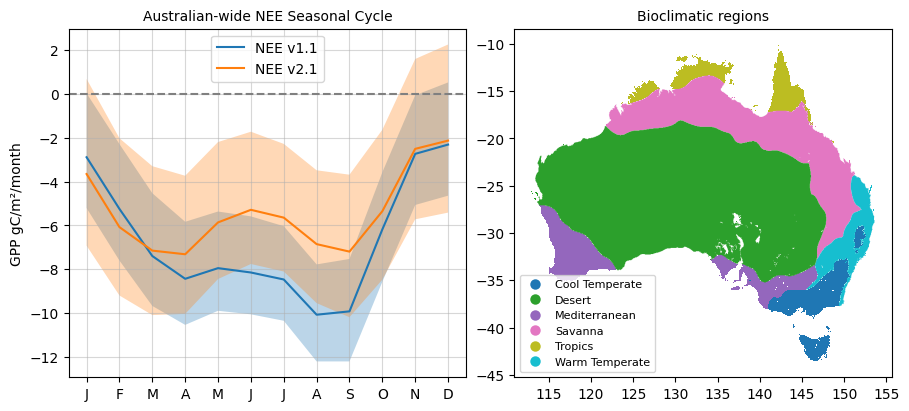

In [11]:
gdf = gpd.read_file('/g/data/xc0/project/AusEFlux/data/bioclim_regions.geojson')

fig, ax = plt.subplots(1,2, figsize=(9,4), layout='constrained')

clim_v1_1D = clim_v1.mean(['latitude', 'longitude'])
clim_v2_1D = clim_v2.mean(['latitude', 'longitude'])

clim_v1_1D[f'{var}_median'].plot(linestyle='-', ax=ax[0], label=f'{var} v1.1', c='tab:blue')
ax[0].fill_between(clim_v1_1D.month, clim_v1_1D[f'{var}_25th_percentile'],
                clim_v1_1D[f'{var}_75th_percentile'], alpha=0.3)

clim_v2_1D[f'{var}_median'].plot(linestyle='-', ax=ax[0], label=f'{var} v2.1', c='tab:orange')
ax[0].fill_between(clim_v2_1D.month, clim_v2_1D[f'{var}_25th_percentile'],
                clim_v2_1D[f'{var}_75th_percentile'], alpha=0.3)

if var=='NEE':
    ax[0].axhline(0, c='grey', linestyle='--')
ax[0].set_title(f'Australian-wide {var} Seasonal Cycle', fontdict={'fontsize': 10})
ax[0].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/month')
ax[0].set_xlabel('')
ax[0].grid(alpha=0.5)
ax[0].set_xticks(range(1,13))
ax[0].legend()
ax[0].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 

gdf.plot(column='region_name', legend=True, figsize=(5,4), ax=ax[1],legend_kwds={'loc':'lower left', 'ncols':1, 'fontsize':8, 'markerscale':0.75} )
ax[1].set_title(f'Bioclimatic regions', fontdict={'fontsize': 10});

### Seasonal cycle per bioregion

In [12]:
# Dictionary to save results 
results_v1 = {}
results_v2 = {}
for index, row in gdf.iterrows():
    # Generate a polygon mask to keep only data within the polygon
    geom = Geometry(geom=gdf.iloc[index].geometry, crs=gdf.crs)
    dss_v1 = clim_v1.odc.mask(poly=geom)
    dss_v2 = clim_v2.odc.mask(poly=geom)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results_v1.update({row['region_name']: dss_v1})
    results_v2.update({row['region_name']: dss_v2})

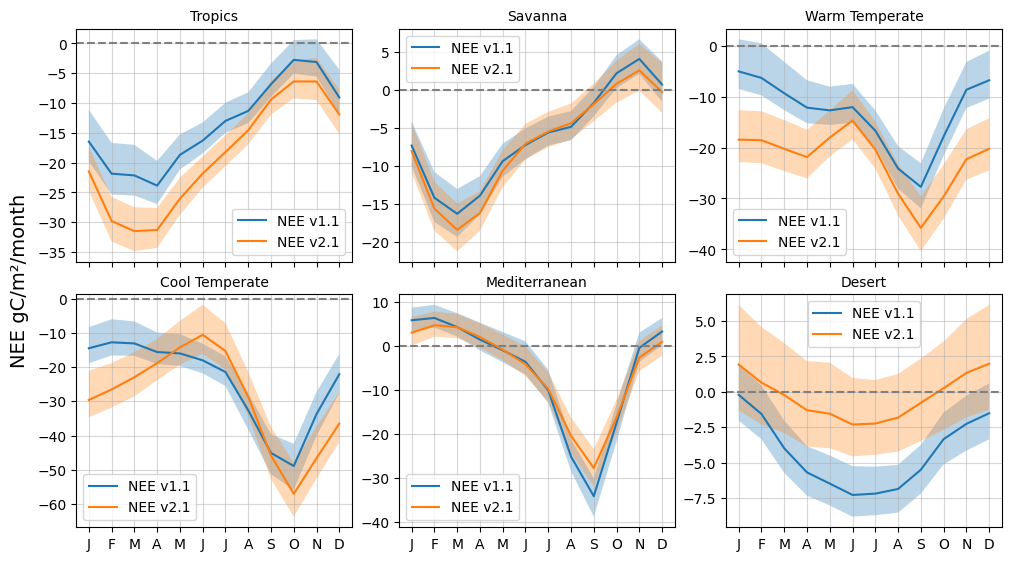

In [13]:
fig, axs = plt.subplots(2,3, figsize=(10,5.5), sharex=True, layout='constrained')

for ax, k in zip(axs.ravel(), results_v1.keys()):
    
    _1D_v1 = results_v1[k].mean(['latitude', 'longitude'])
    _1D_v2 = results_v2[k].mean(['latitude', 'longitude'])
    
    _1D_v1[f'{var}_median'].plot(linestyle='-', ax=ax, label=f'{var} v1.1', c='tab:blue')
    ax.fill_between(_1D_v1.month, _1D_v1[f'{var}_25th_percentile'],
                    _1D_v1[f'{var}_75th_percentile'], alpha=0.3)
    
    _1D_v2[f'{var}_median'].plot(linestyle='-', ax=ax, label=f'{var} v2.1', c='tab:orange')
    ax.fill_between(_1D_v2.month, _1D_v2[f'{var}_25th_percentile'],
                    _1D_v2[f'{var}_75th_percentile'], alpha=0.3)

    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 10})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(alpha=0.5)
    ax.set_xticks(range(1,13))
    ax.legend()
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 

fig.supylabel(f'{var} gC/m\N{SUPERSCRIPT TWO}/month', fontsize=14);

## Trends

In [14]:
trends_v1 = annual_mean_v1[f'{var}_median'].groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']
trends_v2 = annual_mean_v2[f'{var}_median'].groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']

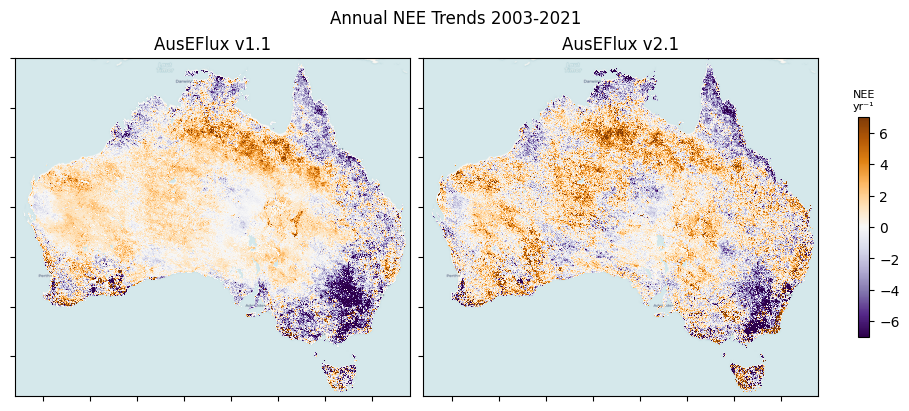

In [15]:
fig,ax = plt.subplots(1,2, figsize=(9,4),sharey=True, layout='constrained')

im = trends_v1.sel(degree=1).plot(ax=ax[0], cmap='PuOr_r', vmin=-7, vmax=7, add_colorbar=False, add_labels=False)
im = trends_v2.sel(degree=1).plot(ax=ax[1], cmap='PuOr_r', vmin=-7, vmax=7, add_colorbar=False, add_labels=False)

ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

ax[0].set_title(label=f'AusEFlux v1.1')
ax[1].set_title(label=f'AusEFlux v2.1')

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

cb = fig.colorbar(im, ax=ax, shrink=0.65, orientation='vertical')
cb.ax.set_title(f'{var}\nyr\u207B\u00B9', fontsize=8);
fig.suptitle(f'Annual {var} Trends 2003-2021');